# School Attendance

## Normalize and clean the data

### Import CSV dataset file into a new DataFrame:

In [1]:
import pandas as pd

path = "School_Attendance_dataset.csv"
df = pd.read_csv(path)

### Drop unused columns:

In [2]:
df = df.drop(columns=["Reporting period", "Date update", "Category", "District code"])

print(df.columns)

Index(['District name', 'Student group',
       '2021-2022 student count - year to date',
       '2021-2022 attendance rate - year to date', '2020-2021 student count',
       '2020-2021 attendance rate', '2019-2020 student count',
       '2019-2020 attendance rate'],
      dtype='object')


### Check for missing data:

In [3]:
print(df.isna().sum())

District name                                0
Student group                                0
2021-2022 student count - year to date       0
2021-2022 attendance rate - year to date     0
2020-2021 student count                     56
2020-2021 attendance rate                   56
2019-2020 student count                     62
2019-2020 attendance rate                   62
dtype: int64


### Check for how spread out the missing data is:

In [4]:
missing_rows = df[df.isna().any(axis=1)]

print(missing_rows["District name"].value_counts())

District name
Goodwin University Educational Services (GUES)     12
Easton School District                              3
Unified School District #2                          3
Great Oaks Charter School District                  3
EdAdvance                                           3
The Woodstock Academy District                      2
Voluntown School District                           2
Ashford School District                             2
Scotland School District                            2
Putnam School District                              2
Regional School District 19                         2
Hebron School District                              2
East Hampton School District                        2
Explorations District                               2
Elm City Montessori School District                 2
Stamford Charter School for Excellence District     2
Trumbull School District                            2
Tolland School District                             1
Interdistrict 

### The missing data is thinly spread across school districts.  It is therefore safe to drop those rows:

In [5]:
df = df.dropna()

print(df.isna().sum())

District name                               0
Student group                               0
2021-2022 student count - year to date      0
2021-2022 attendance rate - year to date    0
2020-2021 student count                     0
2020-2021 attendance rate                   0
2019-2020 student count                     0
2019-2020 attendance rate                   0
dtype: int64


### Normalize student counts and attendance rates:

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

num_cols = [
    "2021-2022 student count - year to date",
    "2021-2022 attendance rate - year to date",
    "2020-2021 student count",
    "2020-2021 attendance rate",
    "2019-2020 student count",
    "2019-2020 attendance rate",
]

df[num_cols] = scaler.fit_transform(df[num_cols])

print(df.head())

  District name                       Student group  \
0   Connecticut                        All Students   
1   Connecticut  Students Experiencing Homelessness   
2   Connecticut          Students With Disabilities   
3   Connecticut                  Free Meal Eligible   
4   Connecticut         Reduced Price Meal Eligible   

   2021-2022 student count - year to date  \
0                                1.000000   
1                                0.003586   
2                                0.156711   
3                                0.337749   
4                                0.059738   

   2021-2022 attendance rate - year to date  2020-2021 student count  \
0                                  0.793782                 1.000000   
1                                  0.470681                 0.003457   
2                                  0.687525                 0.154145   
3                                  0.668634                 0.355200   
4                                  0.7

### One-hot encode the "Student group" column, and then drop it:

In [7]:
dummies = pd.get_dummies(df["Student group"], prefix="Student group", dtype="uint8")

df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=["Student group", "Student group_All Students"])

print(df.head())
print(df.columns)

  District name  2021-2022 student count - year to date  \
0   Connecticut                                1.000000   
1   Connecticut                                0.003586   
2   Connecticut                                0.156711   
3   Connecticut                                0.337749   
4   Connecticut                                0.059738   

   2021-2022 attendance rate - year to date  2020-2021 student count  \
0                                  0.793782                 1.000000   
1                                  0.470681                 0.003457   
2                                  0.687525                 0.154145   
3                                  0.668634                 0.355200   
4                                  0.799685                 0.062221   

   2020-2021 attendance rate  2019-2020 student count  \
0                   0.802395                 1.000000   
1                   0.423486                 0.007664   
2                   0.686627             

## Train model:

### Train the model on first two years and the student groups:

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

dummy_cols = [c for c in df.columns if c.startswith("Student group_")]

feat_train = [
    "2019-2020 student count",
    "2019-2020 attendance rate",
    "2020-2021 student count",
    "2020-2021 attendance rate",
] + dummy_cols

X = df[feat_train].to_numpy()
y = df["2021-2022 attendance rate - year to date"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=17
)
model = HistGradientBoostingRegressor(random_state=17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.04471349949494713


### Use the 3rd year to predict a 4th year:

In [9]:
feat_future = [
    "2020-2021 student count",
    "2020-2021 attendance rate",
    "2021-2022 student count - year to date",
    "2021-2022 attendance rate - year to date",
] + dummy_cols

X_future = df[feat_future].to_numpy()
df["projected_4th_year_attendance_rate"] = model.predict(X_future)

## Clusters

### Scatter Plot By Student Group:

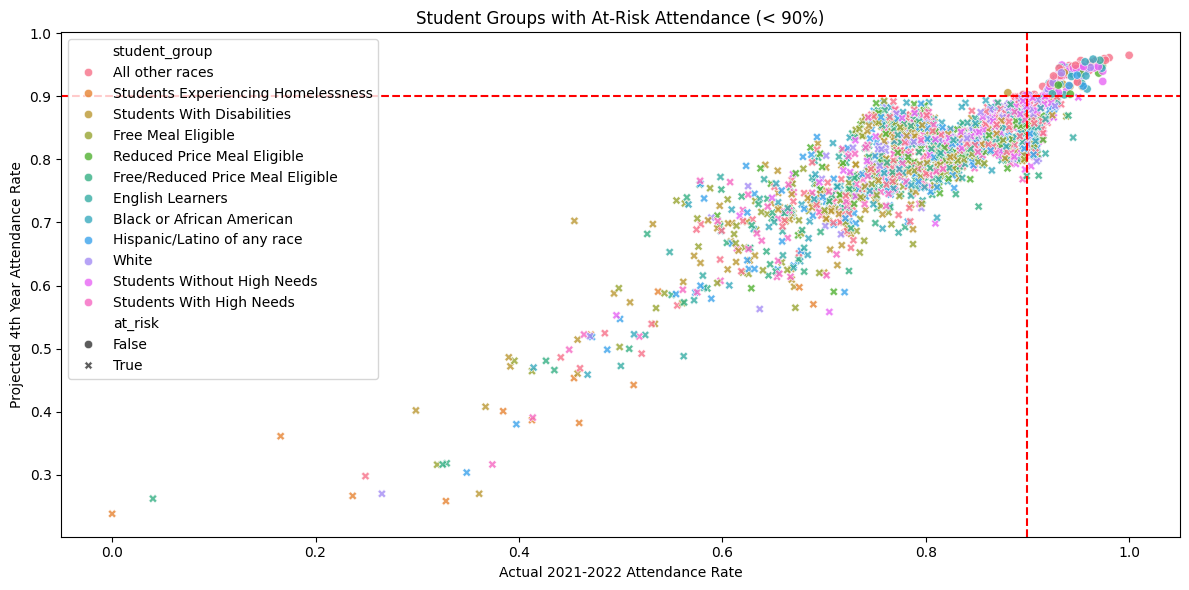

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

threshold = 0.90
df["at_risk"] = df["projected_4th_year_attendance_rate"] < threshold

group_cols = [c for c in df.columns if c.startswith("Student group_")]
df["student_group"] = df[group_cols].idxmax(axis=1).str.replace("Student group_", "")

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="2021-2022 attendance rate - year to date",
    y="projected_4th_year_attendance_rate",
    hue="student_group",
    style="at_risk",
    data=df,
    alpha=0.8,
)
plt.axhline(threshold, color="red", linestyle="--")
plt.axvline(threshold, color="red", linestyle="--")
plt.title("Student Groups with At-Risk Attendance (< 90%)")
plt.xlabel("Actual 2021-2022 Attendance Rate")
plt.ylabel("Projected 4th Year Attendance Rate")
plt.tight_layout()
plt.show()

### Box Plot By Student Group:

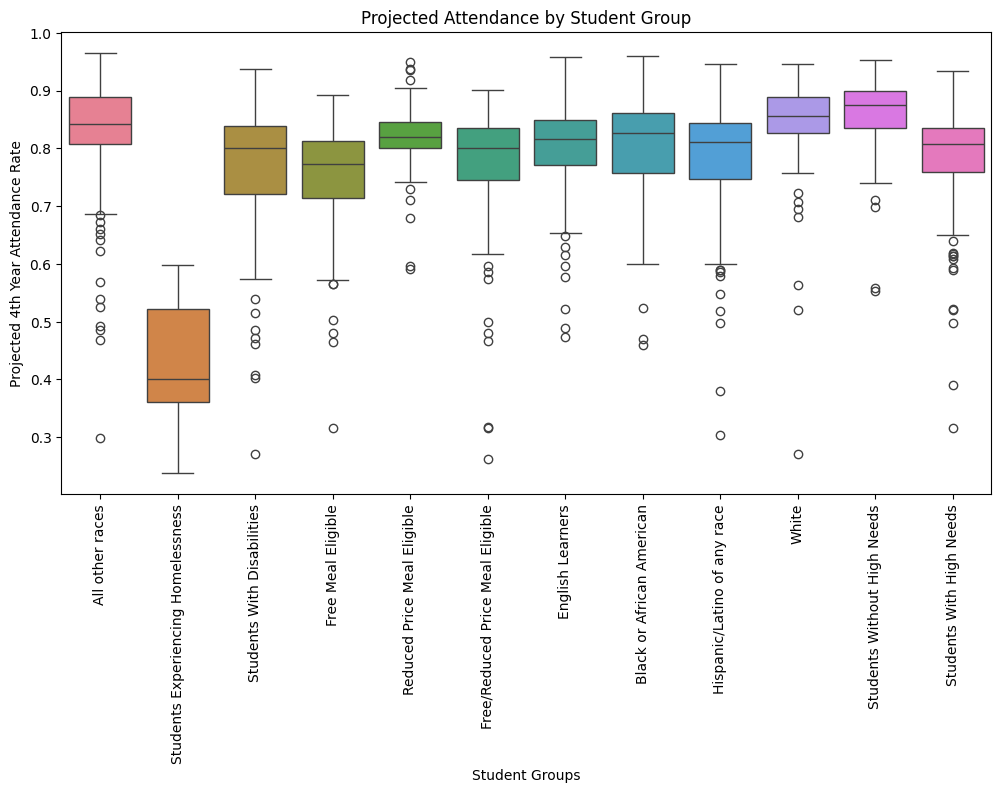

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="student_group", y="projected_4th_year_attendance_rate", data=df, hue="student_group",)
plt.xticks(rotation=90)
plt.title("Projected Attendance by Student Group")
plt.xlabel("Student Groups")
plt.ylabel("Projected 4th Year Attendance Rate")
plt.show()

### Box Plot By School District

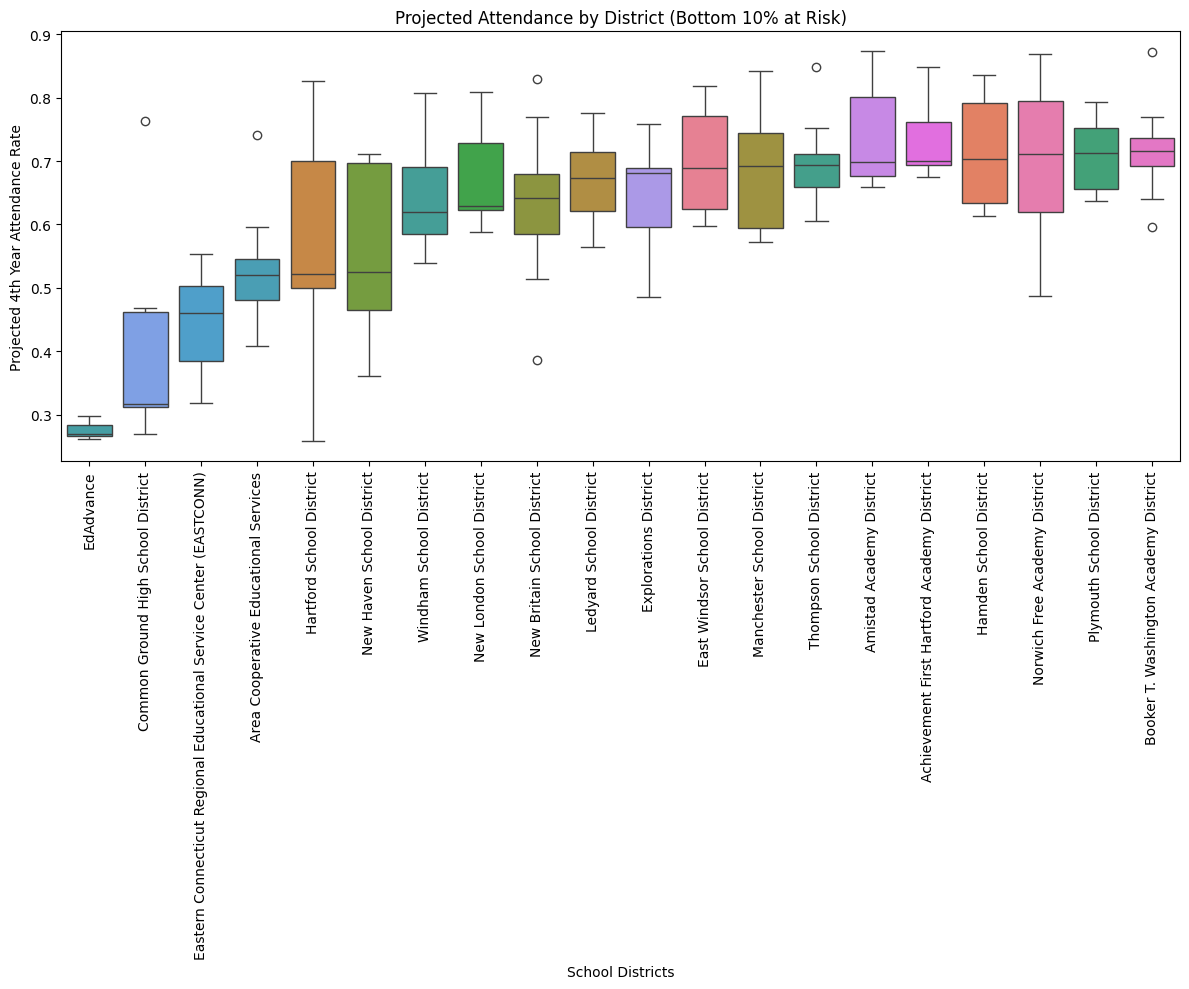

In [12]:
import numpy as np

district_medians = df.groupby("District name")[
    "projected_4th_year_attendance_rate"
].median()

cutoff = np.percentile(district_medians, 10)
at_risk_districts = district_medians[district_medians <= cutoff].index
at_risk_df = df[df["District name"].isin(at_risk_districts)]

plt.figure(figsize=(12, 10))
sns.boxplot(
    x="District name",
    y="projected_4th_year_attendance_rate",
    data=at_risk_df,
    order=district_medians[at_risk_districts].sort_values().index,
    hue="District name",
)
plt.xticks(rotation=90)
plt.ylabel("Projected 4th Year Attendance Rate")
plt.xlabel("School Districts")
plt.title("Projected Attendance by District (Bottom 10% at Risk)")
plt.tight_layout()
plt.show()